# U-Net 구현하기
## Skin Mnist

In [1]:
import lightning as pl

import numpy as np
import pandas as pd
import seaborn as sns

import os
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
from PIL import Image
from pprint import pprint
from torch.utils.data import DataLoader

2023-09-17 15:11:45.590507: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
class SegmentationModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # dice loss as loss function for binary image segmentation
        self.loss_fn = smp.losses.DiceLoss(mode='binary', from_logits=True)

    def forward(self, image):
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def _step(self, batch, stage):
        
        image = batch[0]        # Shape of the image : (batch_size, num_channels, height, width)
        mask = batch[1]

        logits_mask = self.forward(image)
        loss = self.loss_fn(logits_mask, mask)

        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        return {"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn,}

    def _epoch_end(self, outputs, stage):

        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # micro-imagewise - first calculate IoU score for each image and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        output = self._step(batch, "train")
        if not hasattr(self, "train_outputs"):
            self.train_outputs = []
        self.train_outputs.append(output)
        return output

    def on_train_epoch_end(self):
        outputs = self.train_outputs
        self._epoch_end(outputs, "train")
        self.train_outputs = []

    def validation_step(self, batch, batch_idx):
        output = self._step(batch, "valid")
        if not hasattr(self, "valid_outputs"):
            self.valid_outputs = []
        self.valid_outputs.append(output)
        return output

    def on_validation_epoch_end(self):
        outputs = self.valid_outputs
        self._epoch_end(outputs, "valid")
        self.valid_outputs = []

    def test_step(self, batch, batch_idx):
        output = self._step(batch, "test")
        if not hasattr(self, "test_outputs"):
            self.test_outputs = []
        self.test_outputs.append(output)
        return output

    def test_epoch_end(self):
        outputs = self.test_outputs
        self._epoch_end(outputs, "test")
        self.test_outputs = []
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

model = SegmentationModel("Unet", "resnet34", in_channels=3, out_classes=1)

In [3]:
import pandas as pd
from PIL import Image

# CSV 파일에서 데이터 로드
df = pd.read_csv("data/dataset/train.csv")
images= df['image'].tolist()
masks = df['segment'].tolist()
# The following transforms are used on the images
transform = transforms.Compose([
  transforms.Resize((128, 128)),
  transforms.ToTensor(),
])

resized_images = []
for image_path in images[:4000]:
    image = Image.open(image_path)
    resized_image = transform(image)
    resized_images.append(resized_image)

# 마스크 처리
# 만약 마스크도 같은 방식으로 CSV에서 로드된다면, 위와 동일한 방식으로 로드하고 transform 할 수 있습니다.
# 다만, 마스크를 처리하는 로직은 주어진 정보에 따라 조금 더 구체화가 필요할 수 있습니다. 

resized_masks = []
for mask_path in masks[:4000]:  # `mask_paths`는 마스크의 경로를 포함하는 리스트여야 합니다.
    mask = Image.open(mask_path)
    resized_mask = transform(mask)
    if resized_mask.squeeze()[0][0]*resized_mask.squeeze()[0][-1]*resized_mask.squeeze()[-1][0]*resized_mask.squeeze()[-1][-1] == 1:
        resized_mask = -resized_mask.round()+1
    resized_masks.append(resized_mask.round())


In [ ]:
from sklearn.model_selection import train_test_split

train_images,test_images, train_masks,test_masks = train_test_split(resized_images,resized_masks,test_size=0.05)
test_images,val_images, test_masks,val_masks = train_test_split(test_images,test_masks,test_size=0.5)

train_dataset = []
for i in range(len(train_images)):
   train_dataset.append([train_images[i], train_masks[i]])
val_dataset = []
for i in range(len(val_images)):
   val_dataset.append([val_images[i], val_masks[i]])
test_dataset = []
for i in range(len(test_images)):
   test_dataset.append([test_images[i], test_masks[i]])

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

In [27]:
trainer = pl.Trainer(max_epochs=20)

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEV

Sanity Checking: 0it [00:00, ?it/s]

/home/suyeon/.conda/envs/sy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:433: PossibleUserWarning: It is recommended to use `self.log('valid_per_image_iou', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/suyeon/.conda/envs/sy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:433: PossibleUserWarning: It is recommended to use `self.log('train_per_image_iou', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [32]:
trainer.save_checkpoint("./unet/model/model_checkpoint.ckpt") # 모델 저장


In [6]:
# 모델을 초기화할 때 사용된 인자
arch = "Unet"
encoder_name = "resnet34"
in_channels = 3
out_classes = 1

In [7]:
# 모델 불러오기
model = SegmentationModel.load_from_checkpoint("/home/suyeon/code/capstone3/DL/models/unet/model/model_checkpoint.ckpt", arch=arch, encoder_name=encoder_name, in_channels=in_channels, out_classes=out_classes)

In [8]:
trainer.validate(model, dataloaders=val_dataloader)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 trainer.validate(model, dataloaders=val_dataloader)                                          │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trainer' is not defined

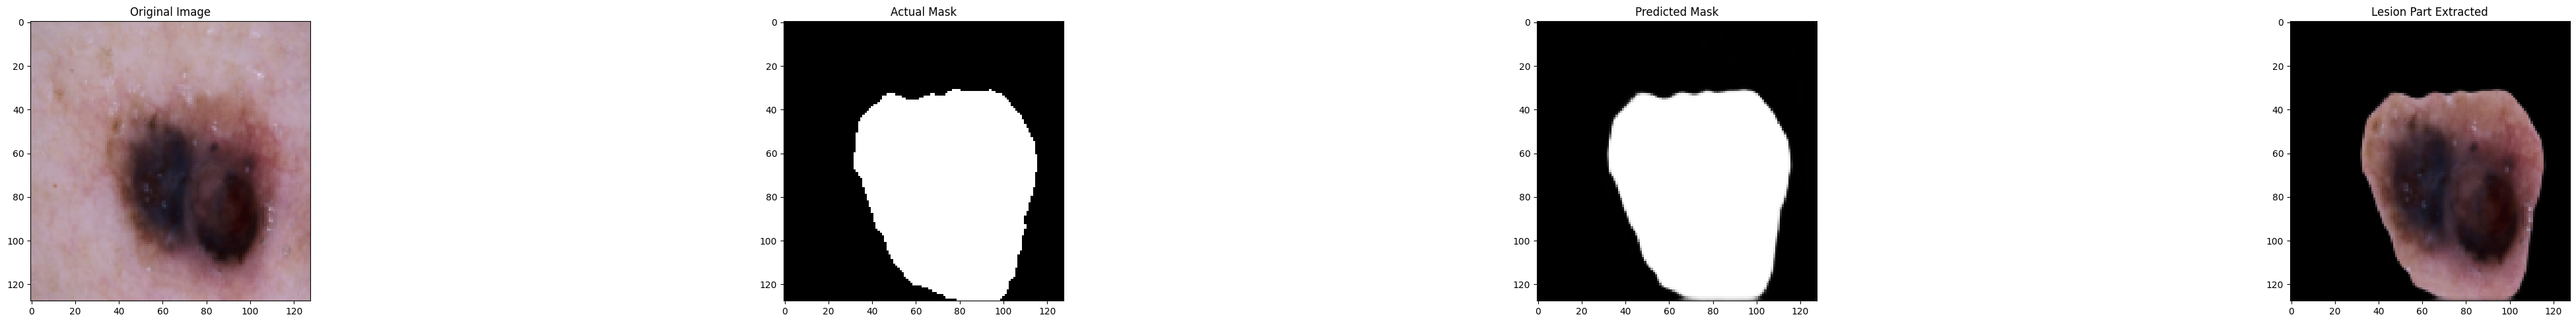

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 테스트 데이터로더에서 샘플 배치 가져오기
sample_images, sample_masks = next(iter(test_dataloader))

# 모델을 평가 모드로 설정
model.eval()

# 모델에 샘플 이미지 전달
with torch.no_grad():
    predictions = model(sample_images.to(model.device))

# 예측 결과를 CPU로 가져오고 sigmoid를 적용하여 확률을 얻기
predicted_masks = predictions.sigmoid().cpu()

# 첫 번째 이미지와 마스크 시각화
fig, ax = plt.subplots(1, 4, figsize=(50, 5))

# 원본 이미지
ax[0].imshow(np.transpose(sample_images[0].numpy(), (1, 2, 0)))
ax[0].set_title("Original Image")

# 실제 마스크
ax[1].imshow(sample_masks[0].squeeze().numpy(), cmap='gray')
ax[1].set_title("Actual Mask")

# 예측된 마스크
ax[2].imshow(predicted_masks[0].squeeze().numpy(), cmap='gray')
ax[2].set_title("Predicted Mask")

# 병변 부분만 추출
lesion_part = np.transpose(sample_images[0].numpy(), (1, 2, 0)) * np.repeat(predicted_masks[0].squeeze().numpy()[:, :, np.newaxis], 3, axis=2)
ax[3].imshow(lesion_part)
ax[3].set_title("Lesion Part Extracted")

plt.tight_layout()
plt.show()



In [43]:
mask_model = model

# ResNET 학습

In [60]:
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp
import timm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# 레이블 딕셔너리 정의
LABEL_DICT = {
    'Actinic keratoses': 0,
    'Basal cell carcinoma': 1,
    'Benign keratosis-like lesions': 2,
    'Dermatofibroma': 3,
    'Melanocytic nevi': 4,
    'Vascular lesions': 5,
    'Melanoma': 6,
}

# 데이터 로드
df = pd.read_csv("data/dataset/train.csv")
images = df['image'].tolist()
labels = df['label'].map(LABEL_DICT).tolist()  # 레이블을 딕셔너리에 매핑

# 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# 이미지 전처리 및 데이터로더 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 데이터 분할
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

# 데이터셋 생성
train_dataset = CustomDataset(train_images, train_labels, transform=transform)
val_dataset = CustomDataset(val_images, val_labels, transform=transform)
test_dataset = CustomDataset(test_images, test_labels, transform=transform)

# 데이터로더 설정
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Unet 모델 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # device 정의를 여기로 이동
unet_model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1).to(device)

# ResNet-50d 모델 로드
resnet_model = timm.create_model('resnet50d', pretrained=True, num_classes=len(LABEL_DICT)).to(device)

# 손실 함수 및 최적화 알고리즘 설정
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001)

# 학습 및 평가 루프
num_epochs = 50

for epoch in range(num_epochs):
    resnet_model.train()
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Unet 모델을 사용하여 마스크 예측
        unet_model.eval()  # Unet 모델을 평가 모드로 설정
        with torch.no_grad():
            masks = [unet_model(image.to(device)) for image in images]
            masks = torch.cat(masks)

        # 원본 이미지와 마스크를 합침
        images_with_mask = images + masks

        # ResNet-50d 모델에 전달
        outputs = resnet_model(images_with_mask)

        # 손실 계산 및 역전파
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 검증 데이터셋을 사용하여 평가
    resnet_model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)

            # Unet 모델을 사용하여 마스크 예측
            unet_model.eval()  # Unet 모델을 평가 모드로 설정
            with torch.no_grad():
                masks = [unet_model(image.to(device)) for image in images]
                masks = torch.cat(masks)

            # 원본 이미지와 마스크를 합침
            images_with_mask = images + masks

            # ResNet-50d 모델에 전달
            outputs = resnet_model(images_with_mask)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}] - Validation Accuracy: {accuracy:.2f}%")

print("Training finished.")

# 테스트 데이터셋을 사용하여 최종 평가
resnet_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Unet 모델을 사용하여 마스크 예측
        unet_model.eval()  # Unet 모델을 평가 모드로 설정
        with torch.no_grad():
            masks = [unet_model(image.to(device)) for image in images]
            masks = torch.cat(masks)

        # 원본 이미지와 마스크를 합침
        images_with_mask = images + masks

        # ResNet-50d 모델에 전달
        outputs = resnet_model(images_with_mask)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

print("Testing finished.")


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:88                                                                                   │
│                                                                                                  │
│    85 │   │   # Unet 모델을 사용하여 마스크 예측                                                 │
│    86 │   │   unet_model.eval()  # Unet 모델을 평가 모드로 설정                                  │
│    87 │   │   with torch.no_grad():                                                              │
│ ❱  88 │   │   │   masks = [unet_model(image.to(device)) for image in images]                     │
│    89 │   │   │   masks = torch.cat(masks)                                                       │
│    90 │   │                                                                                      │
│    91 │   │   # 원본 이미지와 마스크를 합침                                                      │
│                                                                                                  │
│ in <listcomp>:88                                                                                 │
│                                                                                                  │
│    85 │   │   # Unet 모델을 사용하여 마스크 예측                                                 │
│    86 │   │   unet_model.eval()  # Unet 모델을 평가 모드로 설정                                  │
│    87 │   │   with torch.no_grad():                                                              │
│ ❱  88 │   │   │   masks = [unet_model(image.to(device)) for image in images]                     │
│    89 │   │   │   masks = torch.cat(masks)                                                       │
│    90 │   │                                                                                      │
│    91 │   │   # 원본 이미지와 마스크를 합침                                                      │
│                                                                                                  │
│ /home/suyeon/.conda/envs/sy/lib/python3.9/site-packages/torch/nn/modules/module.py:1501 in       │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/suyeon/.conda/envs/sy/lib/python3.9/site-packages/segmentation_models_pytorch/base/model.p │
│ y:29 in forward                                                                                  │
│                                                                                                  │
│   26 │   │                                                                                       │
│   27 │   │   self.check_input_shape(x)                                                           │
│   28 │   │                                                                                       │
│ ❱ 29 │   │   features = self.encoder(x)                                                          │
│   30 │   │   decoder_output = self.decoder(*features)                                            │
│   31 │   │                